In [22]:
import sys
import numpy as np
import pandas as pd 
from skmultiflow.data import DataStream, MultilabelGenerator, ConceptDriftStream
from skmultiflow.meta import ClassifierChain
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from skmultiflow.metrics import hamming_score
from sklearn.metrics import accuracy_score, f1_score
from ld3 import LD3
from skmultilearn.dataset import load_from_arff
from sklearn.preprocessing import MultiLabelBinarizer
from skmultiflow.drift_detection import ADWIN, EDDM, KSWIN, HDDM_W, HDDM_A, DDM, PageHinkley
import util
import warnings
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from river.metrics import ExampleF1
from scipy.stats import truncnorm

warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)

In [27]:
'''n_features = 100
n_targets = 20
s1 = MultilabelGenerator(n_samples=3000, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=0)
s2 = MultilabelGenerator(n_samples=3009, n_features=n_features, n_targets=n_targets, n_labels=2, random_state=250)
stream = ConceptDriftStream(stream=s1, drift_stream=s2, position=2000, width=1, random_state=0)
sample_size=5000'''

X, y = load_from_arff('./datasets/{}'.format('OHSUMED-F.arff'), label_count=23)
X = X.toarray()
y = y.toarray().astype(np.int8)
sample_size = len(X)
n_features = X.shape[1]

if len(np.unique(y)) > 2:
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(y)

n_targets = y.shape[1]
stream = DataStream(data = X, y=y, n_targets=n_targets)

In [28]:
from ld3_ import LD3
detector = LD3(window_size=250, correlation_thresh=-1, correlation_coeff=7) #20NG-1-5   Synthetic-1-6    tmc 0.4-4/5     imbd 1-4     ohsumed 0.05/0.04-4/5
clf = ClassifierChain(PassiveAggressiveClassifier(random_state=0))
pre_sample = [np.zeros(n_features), np.zeros(n_features)]
pre_label = [np.ones(n_targets), np.zeros(n_targets)]
clf.fit(np.array(pre_sample), np.array(pre_label))

stream.restart()
max_samples = sample_size
y_true = []
y_pred = []
pretrain_X = []
pretrain_y = []
correlation_list = []
p_bar = tqdm(total=max_samples)
n_samples = 0
drift, warning = False, False
correlation = 0
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    if n_samples % 100 == 0 and n_samples >500:
        print(detector._average_correlation)
            
    '''if n_samples >= 1990 and n_samples <= 2050:
        print('Correlation @', n_samples, ': ', correlation)
        #print(detector._average_correlation)
        r1, r2 = detector._ranks
        print('[',','.join(list(map(str,r1))), ']', '\t[', ','.join(list(map(str,r2))), ']')'''
    if drift:
        print('Drift@', n_samples)
        r1, r2 = detector._ranks
        print('[',','.join(list(map(str,r1))), ']', '\t[', ','.join(list(map(str,r2))), ']')
        clf.reset()
        clf.fit(np.array(pre_sample), np.array(pre_label))

    pred = clf.predict(X)
    #clf.partial_fit(X, np.array([y]))
    clf.partial_fit(X, y)
    drift, warning, correlation = detector.update(pred.astype(np.int32))
    if correlation > 0:
        correlation_list.append(correlation)
    #detector.add_element(np.all(pred.flatten() == y))

    #y_true.append(y)
    y_true.extend(y)
    y_pred.extend(pred)

    p_bar.update(1)
    n_samples += 1
p_bar.close()
stream.restart()

print()
print(accuracy_score(np.array(y_true), np.array(y_pred)))
print(hamming_score(np.array(y_true), np.array(y_pred)))
print(f1_score(np.array(y_true), np.array(y_pred), average='samples'))
print(f1_score(np.array(y_true), np.array(y_pred), average='micro'))
print(f1_score(np.array(y_true), np.array(y_pred), average='macro'))
print()

  0%|          | 0/13929 [00:00<?, ?it/s]

0.8975898250495303
0.832125284282492
0.8637244000676338
0.8523041310203827
0.9297173789017146
0.8590122117057412
0.8144373057343229
0.7660403613775262
0.7614039372226484
0.7586086064979163
0.731249692099026
0.7232856576271878
0.6919364195177344
0.6956344102779146
0.7015414996617797
0.6921930058121121
0.8023804198840646
0.8299759498039798
0.7367024267338356
0.7071654239437581
0.6769805075034305
0.692259487510259
0.6801319256641395
0.7786985898038505
0.779617302597714
0.7608719620030936
0.6300635333035801
0.6071553216782954
0.7218793060090368
0.6443034566541144
0.6161542228634154
0.6365144163160124
0.5965852882814038
0.4744874481141866
0.6471136793312006
0.6736999749892112
0.6306927065893071
0.5521292423094635
0.5136324306293728
0.477740562510902
0.3698112852434335
0.44236604976772675
0.5489975557827159
0.5293668105666736
0.4206989786155734
0.545416095022883
0.4741873151592366
0.19047527959069635
0.14185206291297403
0.09066228914043015
0.2139694569363212
0.358839242741067
0.2600932143690

In [29]:
mu, sigma = 0.54,  # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

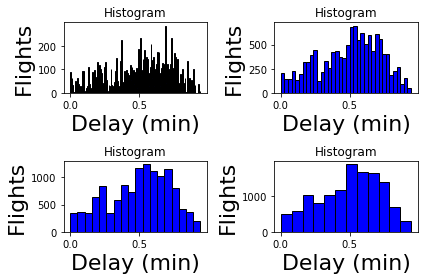

In [31]:
for i, binwidth in enumerate([1, 5, 10, 15]):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(correlation_list, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
    ax.set_title('Histogram')
    ax.set_xlabel('Delay (min)', size = 22)
    ax.set_ylabel('Flights', size= 22)

plt.tight_layout()
plt.show()

In [32]:
sort = np.argsort(correlation_list)
print(np.array(correlation_list)[sort[:int(len(correlation_list)/1000)]])

[0.0001 0.0001 0.0002 0.0002 0.0002 0.0008 0.0008 0.0008 0.0008 0.0008
 0.0008 0.0008]


In [6]:
print(accuracy_score(np.array(y_true), np.array(y_pred)))
print(hamming_score(np.array(y_true), np.array(y_pred)))
print(f1_score(np.array(y_true), np.array(y_pred), average='samples'))
print(f1_score(np.array(y_true), np.array(y_pred), average='micro'))


0.04770962379774891
0.8903891388922691
0.23064926923800752
0.24206504001944298
0.13854895326189495

0.556321243523316
0.9675984455958548
0.6144031581544535
0.6688729448518704
0.6691942897702132

0.1144
0.8734999999999999
0.2947831131187653
0.323022583752542

0.1052
0.8694000000000001
0.3114175971854233
0.3364495478101819

0.1172
0.8736599999999999
0.3097356535734796
0.3377018242818201


0.19525360420889606
0.9708287566406674
0.6235609037722215
0.6623583731145778



0.1162
0.87316
0.29535096381878995
0.3232312453313414


0.6623583731145778

In [7]:
detectors = [ADWIN(), EDDM(), DDM()]
for detector in detectors:
    #detector = EDDM()#LD3(k=1, window_size=500)
    clf = ClassifierChain(PassiveAggressiveClassifier(random_state=0))
    pre_sample = [np.zeros(n_features), np.zeros(n_features)]
    pre_label = [np.ones(n_targets), np.zeros(n_targets)]
    clf.fit(np.array(pre_sample), np.array(pre_label))


    max_samples = sample_size
    y_true = []
    y_pred = []
    pretrain_X = []
    pretrain_y = []
    p_bar = tqdm(total=max_samples)
    n_samples = 0

    while n_samples < max_samples and stream.has_more_samples():
        X, y = stream.next_sample()

        if detector.detected_change():
            print('Drift@', n_samples)
            detector.reset()
            clf.reset()
            clf.fit(np.array(pre_sample), np.array(pre_label))

        pred = clf.predict(X)
        #clf.partial_fit(X, np.array([y]))
        clf.partial_fit(X, y)
        #detector.add_element(pred.astype(np.int32))
        #detector.add_element(np.all(pred.flatten() == y))
        detector.add_element((pred.astype(np.int32).flatten().tolist())==(y.astype(np.int32).flatten().tolist()))

        #y_true.append(y)
        y_true.extend(y)
        y_pred.extend(pred)

        p_bar.update(1)
        n_samples += 1
    
    print(accuracy_score(np.array(y_true), np.array(y_pred)))
    print(hamming_score(np.array(y_true), np.array(y_pred)))
    print(f1_score(np.array(y_true), np.array(y_pred), average='samples'))
    print(f1_score(np.array(y_true), np.array(y_pred), average='micro'))
    print()

    stream.restart()

  0%|          | 0/5000 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
print(accuracy_score(np.array(y_true), np.array(y_pred)))
print(hamming_score(np.array(y_true), np.array(y_pred)))
print(f1_score(np.array(y_true), np.array(y_pred), average='samples'))
print(f1_score(np.array(y_true), np.array(y_pred), average='micro'))

In [10]:
a = np.array([1, 19, 3, 8, 5, 18, 4, 2, 0, 13, 11, 7, 17, 6, 9, 10, 12, 14, 15, 16])
b = np.array([19, 1, 2, 7, 3, 5, 18, 17, 13, 4, 8, 11, 0, 10, 6, 12, 9, 14, 15, 16]) 

c = np.array([19, 1, 2, 17, 10, 18, 7, 8, 3, 12, 4, 6, 5, 13, 11, 9, 14, 15, 0, 16])
d = np.array([19, 2, 1, 8, 18, 5, 17, 3, 13, 12, 4, 6, 7, 10, 11, 9, 14, 15, 16, 0]) 

x = np.array([ 1,8,19,5,13,0,17,2,18,11,3,6,9,10,12,4,7,14,15,16 ])
y = np.array([ 19,2,1,8,18,10,12,5,3,4,7,6,11,9,13,17,14,0,15,16 ])

e = np.array([ 8,19,17,1,3,5,0,9,18,2,4,6,11,7,13,12,10,14,15,16 ])
f = np.array([ 19,1,2,8,7,18,5,3,4,13,11,10,17,0,6,12,9,14,15,16 ])

In [3]:
argx = (np.argsort(a)).astype(np.float)#np.arange(1,21,1).astype(np.float)
argy = (np.argsort(b)).astype(np.float)#np.flip(np.arange(1,21,1)).astype(np.float) 
maxx = np.arange(1,21,1).astype(np.float)
maxy = np.flip(np.arange(1,21,1)).astype(np.float) 

'''for i in range(20):
    argx[i] *= 1/(argx[i]+1)
    argy[i] *= 1/(argy[i]+1)
    maxx[i] *= 1/(maxx[i]+1)
    maxy[i] *= 1/(maxy[i]+1)'''



'for i in range(20):\n    argx[i] *= 1/(argx[i]+1)\n    argy[i] *= 1/(argy[i]+1)\n    maxx[i] *= 1/(maxx[i]+1)\n    maxy[i] *= 1/(maxy[i]+1)'

In [9]:
print(argx)
print(argy)

[ 8.  0.  7.  2.  6.  4. 13. 11.  3. 14. 15. 10. 16.  9. 17. 18. 19. 12.
  5.  1.]
[12.  1.  2.  4.  9.  5. 14.  3. 10. 16. 13. 11. 15.  8. 17. 18. 19.  7.
  6.  0.]


In [6]:
def WS(rx, ry):
    sum_ = 0
    ranks_x = np.argsort(rx)
    ranks_y = np.argsort(ry)
    for i in range(len(rx)):
        sum_ += (1/(2**(ranks_x[i]))) * ((np.abs(ranks_x[i] - ranks_y[i]))/(np.max([np.abs(1-ranks_x[i]), np.abs(len(rx) - ranks_x[i])])))
    return 1 - sum_

In [14]:
WS(e,f)

0.6403404417406884

In [9]:
a = [1,2,3,4,5]
b = [5,4,3,2,1]
WS(a, b)

-0.2583333333333333

In [11]:
from scipy.stats import kendalltau, spearmanr
spearmanr(x[:5],y[:5])

SpearmanrResult(correlation=-0.7, pvalue=0.1881204043741873)

In [12]:
from scipy.spatial.distance import correlation
correlation(argx,argy)

0.15639097744360897

In [13]:
def dist(x, y, w):
    sum_ = 0
    for i in range(len(x)):
        abs_ = np.abs(x[i] - y[i])
        add =  abs_*w[i] if abs_ > 1 else 0
        sum_ += add
    return sum_
        

In [14]:
from scipy.spatial import distance
((dist(argx, argy, w=1/((3)**(argy*argy))) / np.sqrt(len(argx))) + (dist(argx, argy, w=1/((3)**(argx*argx))) / np.sqrt(len(argx)))) / 2 #/ 0.05617535148406078

0.00974723033648846

In [15]:
def rank_correlation(x, y, dist=distance.correlation):
        c = np.array([dist(x[i], y[i]) * (1/((y[i]))) for i in range(len(x))]).sum()
        return c
rank_correlation(argx, argy)

nan

In [16]:
1/argy

array([0.0833, 1.    , 0.5   , 0.25  , 0.1111, 0.2   , 0.0714, 0.3333,
       0.1   , 0.0625, 0.0769, 0.0909, 0.0667, 0.125 , 0.0588, 0.0556,
       0.0526, 0.1429, 0.1667,    inf])

In [17]:
from scipy.spatial import distance
dist = distance.cityblock # * 1/((argy[i])**2)
s = np.array([dist(argx[i], argy[i]) * 1/((argy[i])**2) for i in range(20)]).sum()

'''for i in range(20):
    s += dist(argx[i], argy[i]) * 1/((argy[i])**2)'''

smax = 0
for i in range(20):
    smax += dist(argx[i], argx[i]) * 1/((argy[i])**2)

print(s)

inf


In [18]:
0.5429113076754074
55.77
weigher = lambda r: 1/((1+r)**2)
print(weightedtau(a,b,rank=True, additive=False, weigher=weigher))
print(weightedtau(c,d,rank=True, additive=False, weigher=weigher))
print(weightedtau(x,y,rank=True, additive=False, weigher=weigher))

WeightedTauResult(correlation=-0.6713827328914972, pvalue=nan)
WeightedTauResult(correlation=0.3524122261236008, pvalue=nan)
WeightedTauResult(correlation=-0.7990832874910562, pvalue=nan)


In [19]:
print(np.where(a==b)[0])
print(np.where(c==d)[0])
print(np.where(x==y)[0])

[17 18 19]
[ 1 10]
[11 18 19]


In [20]:
weigher = lambda r: 1/((r+1))
print(weightedtau(np.argsort(a),np.argsort(b),rank=False, additive=False, weigher=weigher))
print(weightedtau(np.argsort(c),np.argsort(d),rank=False, additive=False, weigher=weigher))
print(weightedtau(np.argsort(x),np.argsort(y),rank=False, additive=False, weigher=weigher))

WeightedTauResult(correlation=0.6962121412338664, pvalue=nan)
WeightedTauResult(correlation=0.07118840640971633, pvalue=nan)
WeightedTauResult(correlation=0.18079986971236403, pvalue=nan)
